In [105]:
import pandas as pd
import os
import warnings

# 모든 경고를 무시하도록 설정
warnings.filterwarnings('ignore')

forecast = pd.read_csv(os.path.join("Data", "forecast.csv"), index_col=0)
weather = pd.read_csv(os.path.join("Data", "weather.csv"), index_col=0)

load    = pd.read_csv(os.path.join("Data", "load.csv"), index_col=0)
load_e  = load[:-24]
test    = load.iloc[-24:]

merged_factor = weather.join(forecast)

# 부하 패턴 군집화

In [21]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import pickle

def create_sequences_set(y, time_steps=24, n_days=1):
    yy, ys = [], []
    for i in range(len(y) - n_days * time_steps):
        yy.append(list(y[i:i + time_steps])+ [y[i + time_steps]])
        ys.append(y[i:i + time_steps])
    return yy, np.array(ys)

def create_sequences_data(X, y, time_steps=24):
    xx, yy =[], []
    for i in range(0, len(y), time_steps):
        xx.append(X[i:i+time_steps])
        yy.append(y[i:i+time_steps])
    
    return np.array(xx), np.array(yy)

for name in load.columns:
    load_data = load[name]

    # 입출력 분리
    y = load_data  # 건물동 발전량

    # 시퀀스
    time_steps = 24
    seq_x, seq_y = create_sequences_data(merged_factor, y, time_steps=24)
    seq_y = np.array(seq_y).reshape(len(seq_y), 24)

    k = 7


    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=0, max_iter=10, dtw_inertia=True, random_state=123, tol=0.001, n_jobs=-1, n_init=10)
    y_pred = model.fit_predict(seq_y)

    # 모델 저장
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_load_{name.replace("/", "")}.pkl'), 'wb') as f:
        pickle.dump(model, f)

    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_load_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)


In [23]:
# # sz = y_pred.shape[0]
# sz = time_steps

# for yi in range(k):
    
#     # plt.subplot(10, 5, 1 + yi)
#     plt.figure(figsize=(8, 8))
#     for xx in seq_y[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(model.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(0, 1000)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("DBA $k$-means")

# xgb 모델 생성

In [67]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pickle
from sklearn.model_selection import GridSearchCV

k = 7

for name in load_e.columns:
    
    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_load_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)

    load_data = load_e[name]

    factor = merged_factor.copy()

    load_df = pd.DataFrame(load_data)
    load_df_c = pd.concat([load_df[name], factor], axis=1)


    time_steps = 24
    seq_x, seq_y = create_sequences_data(factor, load_data, time_steps=time_steps)
    seq_y = np.array(seq_y).reshape(len(seq_y), 24)

    seq_pred = loaded_model.fit_predict(seq_y)

    # X = np.array(load_data[:24]).reshape(1,-1)      # 임시
    # cl_indice = loaded_model.predict(X)

    

    cl_list = []


    for i in range(k):
        cl_indice = i
        a = seq_pred == i
        cl_ = np.where(a == True)[0].tolist()

        cl_list.append(cl_)


        load_cl_sub = pd.DataFrame(columns=load_df_c.columns)

        # 군집별로 데이터프레임 추출 후 학습
        for ele in cl_list[int(cl_indice)]:
            si = ele * 24
            ei = (ele+1) * 24

            sub_df = load_df_c.iloc[si:ei]
            load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)



        X = load_cl_sub.drop(columns=name)
        y = load_cl_sub[name]

        # 데이터 스케일링
        scaler = MinMaxScaler()

        scaled_X = scaler.fit_transform(X)
        scaled_y = scaler.fit_transform(np.array(y).reshape(-1,1))


        X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=42)

        

        # 하이퍼파라미터 그리드 설정
        param_grid = {
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300]
        }

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0)
        grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', verbose=1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)

        # 모델 저장
        best_model.save_model(os.path.join("Data","model_xgb", f'xgb_load_{name.replace("/", "")}_{cl_indice}.json'))

        # 성능 평가 (평균 제곱 오차)
        mse = mean_squared_error(y_test, y_pred)
        print(f"col: {name}, Mean Squared Error: {mse}")
                

/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.008472549386037694
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.017452717077888136
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.010059380805801505
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.019587162043408584
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.005466012128650639
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.004969501113793262
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.00859170026375202


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.0043385539172182165
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.008087681389596622
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.00820931810225104
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013203504444417511
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.009677713702538508
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01184183611645767
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.021631812114344826


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.014854393587848427
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0202867345740301
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.03425209678865286
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01236163817206773
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0457034778922836
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.022506131069244137
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.015773695546975407


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.014309529146440103
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0066486724577395715
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.027304053505220412
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.012884708441935084
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.011412641819276058
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013506355300175743
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.018748870961691238


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.008980369024256156
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.016073979870610287
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.008268842200503917
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.011983916345051736
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.034243733380962885
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.010174190164774959
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.012657539089341512


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.0318388775180575
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.03331657755118106
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.024055257510745883
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.019410026102072438
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.015406622080505541
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.02475118097483496
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.022794018767626538


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.02723157465266138
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.020944996196294075
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01413221890145472
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.02047189733807609
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01960675005473999
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01578396281898008
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.016537832155420876


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.013325951872514232
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.011088282298214357
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01859828906446306
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.009362515390203925
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.06659478258605168
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01002208776479599
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01486802379124949


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.013934690678319924
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.006616154137928971
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.023415505440142346
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01691612864046797
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.020367498601931253
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.012433007262412187
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.011726689900444145


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.016153542693561153
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.019753623053073936
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.006145676876545525
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.015792434180767735
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013540939437595122
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01810862595001699
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.011811679363587317


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.0
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.005751099527892443
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.009118274989198857
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0035972421103933677
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.04824180167460335
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.010008355012889826
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.00803744889759485


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.007827927091184067
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.009000247628051619
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.014077944988244235
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01129179665980394
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.008067755557066823
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.06748528778881695
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.005990751559423753


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.002492029596921688
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0107697888007707
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.012338192548886266
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0171124202305884
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013022788972929515
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.022243376419380616
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.025468716326417114


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.10414834949486484
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.022433577785996212
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.019966978949258387
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.03105584764956463
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.020182842194821273
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.024213328673083654


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.010094251195888368
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.029886347470168335
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01166613911403471
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.016365394792165814
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013154983692482485
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0104981206613238
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.014565826891027893


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.01833853270849803
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013568246433430185
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.010314170931678785
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.012818207483854855
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0074258270427157895
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.007906514982621005
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0062246601416731575


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.0025330793185965204
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.008505870789036281
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.02026288622289083
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01902597411468056
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.016881533486620776
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013995265946502959
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.028323956928963463


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.0483892117730676
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.006727625638498959
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.011788746577993534
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013757579326217089
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.019032011384512337
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013603618510328803
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.008980894563775446


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.020491791627103143
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.005316246749329071
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0076906055064250205
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.008337072653356856
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.08173129726664159
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.0065843009431067814
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.013843810862722766


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error: 0.03685914128230052
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.034971159973529994
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.02735646943303027
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.00800411712079351
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.012882401876581687
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.018855795043209472
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_18434/2817611101.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  load_cl_sub = pd.concat([load_cl_sub, sub_df], axis=0)


Mean Squared Error: 0.01527523239727552


# 30 예측(31 없으므로)

In [106]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

RESULT = []

for name in load_e.columns:
    factor = merged_factor[-48:-24]
    
    test_value = test[name]
    test_df = pd.concat([test_value, factor], axis=1)

    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_load_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)

    # 부하 모형 분류
    cl_indice = int(loaded_model.predict(np.array(test_value).reshape(1,-1)))

    scaler = MinMaxScaler()
    X = test_df.drop(columns=name)
    y = test_df[name]

    test_X = scaler.fit_transform(X)
    test_y = scaler.fit_transform(np.array(y).reshape(1,-1))[0]
    
    # xgb-k 모델 불러오기
    xgbk = xgb.Booster()
    xgbk.load_model(os.path.join("Data","model_xgb", f'xgb_load_{name.replace("/", "")}_{cl_indice}.json'))

    # 예측
    dtest = xgb.DMatrix(test_X)
    y_pred = xgbk.predict(dtest)

    output = scaler.inverse_transform(y_pred.reshape(1,-1))
    RESULT.append(output)

    # 성능 평가 (평균 제곱 오차)
    mse = mean_squared_error(test_y, y_pred)
    print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.30907089270574656
Mean Squared Error: 0.23806423419110614
Mean Squared Error: 0.3544584209651038
Mean Squared Error: 0.4143878858135462
Mean Squared Error: 0.35507645443830366
Mean Squared Error: 0.32421513634171484
Mean Squared Error: 0.2630880081570565
Mean Squared Error: 0.32953240727130134
Mean Squared Error: 0.24443592022359617
Mean Squared Error: 0.2750079931539684
Mean Squared Error: 0.4317813646125737
Mean Squared Error: 0.1891894724640837
Mean Squared Error: 0.1570558326902816
Mean Squared Error: 0.4332905770087421
Mean Squared Error: 0.21073828377580953
Mean Squared Error: 0.39997608475211494
Mean Squared Error: 0.228367724793179
Mean Squared Error: 0.3880232591881605
Mean Squared Error: 0.0
Mean Squared Error: 0.10379604352868282


In [107]:
result = np.zeros((1,24))
for v in RESULT:
    result = result + v

pd.DataFrame(result.reshape(24,1), columns=["load"]).to_csv(os.path.join("result", "LOAD_RESULT.csv"))

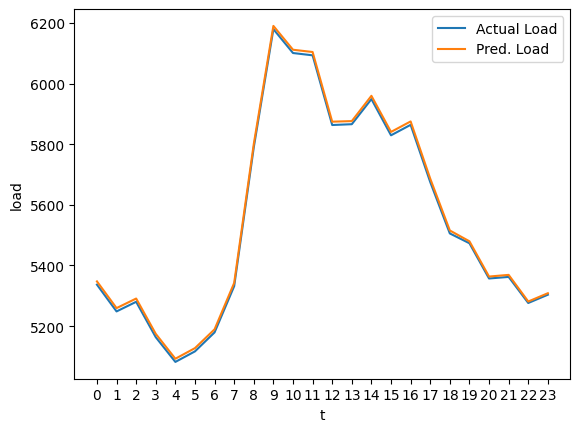

In [110]:
result_ = result.tolist()[0]
test_ = test.sum(axis=1)

plt.xlabel('t')
plt.ylabel('load')
plt.xticks(ticks=[i for i in range(24)], labels=[i for i in range(24)])

plt.plot(test_, label="Actual Load")
plt.plot(result_, label="Pred. Load")

plt.legend()